In [7]:
import os
import numpy as np

from sunpy.net import Fido, attrs as a
import astropy.units as u

import sunpy.map
from astropy.io import fits

from aiapy.calibrate import correct_degradation
from aiapy.calibrate.util import get_correction_table
import aiapy.psf

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import cv2
from PIL import Image

import shutil

import time
import datetime
from dateutil.relativedelta import relativedelta

from concurrent.futures import ThreadPoolExecutor

In [17]:
download_dir = 'D:/aia_synoptic_data'

# List all files in the download directory
aia_files = [os.path.join(download_dir, f) for f in os.listdir(download_dir) if f.endswith('.fits')]

In [12]:
new_aia_files = [os.path.join(download_dir, f) for f in os.listdir(download_dir) if f.endswith('.fits')]

In [18]:
# Find elements that are unique to each list
unique_new_files = list(set(new_aia_files) - set(aia_files))


print(f"Original aia_files count: {len(aia_files)}")
print(f"Original new_aia_files count: {len(new_aia_files)}")
print(f"Files unique to new_aia_files: {len(unique_new_files)}")

Original aia_files count: 121975
Original new_aia_files count: 123688
Files unique to new_aia_files: 1713


In [15]:

def fix_aia_files(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        # Disable memory mapping and use a context manager
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            hdul.verify('fix')
            # hdul[1].header.remove('TEMPSMIR', ignore_missing=True)
            # hdul[1].header.remove('TEMPFPAD', ignore_missing=True)
            # hdul[1].header.remove('TEMPCCD', ignore_missing=True)
            # hdul[1].header.remove('OSCNRMS', ignore_missing=True)
            # hdul[1].header.remove('OSCNMEAN', ignore_missing=True)
            # hdul[1].header.remove('TEMPGT', ignore_missing=True)
            # No need to close when using context manager
    except TypeError as e:
        if "buffer is too small" in str(e):
            print(f"Buffer error in file {aia_file_path}: {e}")
            return f"BUFFER ERROR: {aia_file_path}"
        return f"TYPE ERROR: {aia_file_path}, Error: {e}"
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(fix_aia_files, unique_new_files), total=len(unique_new_files), desc="Fixing AIA Files"))


2025-03-08 07:13:57 - astropy - WARNING: VerifyWarning:         Card 'OSCNMEAN' is not FITS standard (invalid value string: '-nan').  Fixed 'OSCNMEAN' card to meet the FITS standard.
2025-03-08 07:13:57 - astropy - WARNING: VerifyWarning:         Card 'OSCNRMS' is not FITS standard (invalid value string: '-nan').  Fixed 'OSCNRMS' card to meet the FITS standard.
2025-03-08 07:13:57 - astropy - WARNING: VerifyWarning:     Card 57:
2025-03-08 07:13:57 - astropy - WARNING: VerifyWarning:     Card 78:
2025-03-08 07:13:57 - astropy - WARNING: VerifyWarning:     Card 98:


Fixing AIA Files:   0%|          | 0/7498 [00:00<?, ?it/s]

2025-03-08 07:13:59 - astropy - WARNING: VerifyWarning:     Card 79:
2025-03-08 07:13:59 - astropy - WARNING: VerifyWarning:         Card 'SAT_Y0' is not FITS standard (invalid value string: 'nan').  Fixed 'SAT_Y0' card to meet the FITS standard.
2025-03-08 07:13:59 - astropy - WARNING: VerifyWarning:     Card 80:
2025-03-08 07:13:59 - astropy - WARNING: VerifyWarning:         Card 'SAT_Z0' is not FITS standard (invalid value string: 'nan').  Fixed 'SAT_Z0' card to meet the FITS standard.
2025-03-08 07:13:59 - astropy - WARNING: VerifyWarning:     Card 81:
2025-03-08 07:13:59 - astropy - WARNING: VerifyWarning:         Card 'SAT_ROT' is not FITS standard (invalid value string: 'nan').  Fixed 'SAT_ROT' card to meet the FITS standard.
2025-03-08 07:14:05 - astropy - WARNING: VerifyWarning:     Card 82:
2025-03-08 07:14:14 - astropy - WARNING: VerifyWarning:     Card 74:
2025-03-08 07:14:14 - astropy - WARNING: VerifyWarning:         Card 'X0_MP' is not FITS standard (invalid value string

In [16]:
bad_quality_files = []
def check_file_quality(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            # Check if the quality is bad add to the list
            if header['QUALITY'] != 0:
                bad_quality_files.append(aia_file_path)
                # print(f"Bad quality file: {file}")
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    

    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(check_file_quality, unique_new_files), total=len(unique_new_files), desc="Checking file quality"))

print(len(bad_quality_files))

bad_quality_files_file = os.path.join(download_dir, 'bad_quality_files.txt')
with open(bad_quality_files_file, 'w') as f:
    for file in bad_quality_files:
        f.write(f"{file}\n")
        
        
# delete all bad quality files
for bad_file in bad_quality_files:
    os.remove(bad_file)
    



Checking file quality:   0%|          | 0/7498 [00:00<?, ?it/s]

1673


In [19]:
correction_table = get_correction_table("JSOC")
print("Got correction table")

def correct_degradation_file(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            aia_map = sunpy.map.Map((data, header))
            aia_map_corrected = correct_degradation(aia_map, correction_table=correction_table)
            hdul[1].data = aia_map_corrected.data
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"

    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(correct_degradation_file, aia_files), total=len(aia_files), desc="Degradation Correction"))

Got correction table


Degradation Correction:   0%|          | 0/121975 [00:00<?, ?it/s]

2025-03-08 08:51:27 - astropy - WARNING: File may have been truncated: actual file length (1007616) is smaller than the expected size (1206720)
2025-03-08 08:51:27 - astropy - WARNING: File may have been truncated: actual file length (1007616) is smaller than the expected size (1203840)
2025-03-08 08:51:27 - astropy - WARNING: File may have been truncated: actual file length (1155072) is smaller than the expected size (1203840)


In [20]:
def normalize_by_exposure(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            aia_map = sunpy.map.Map((data, header))
            aia_map_normalized = aia_map / aia_map.exposure_time
            hdul[1].data = aia_map_normalized.data
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"

    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(normalize_by_exposure, aia_files), total=len(aia_files), desc="Normalizing by Exposure Time"))


Normalizing by Exposure Time:   0%|          | 0/121975 [00:00<?, ?it/s]

Calculating pixel distribution:   0%|          | 0/10000 [00:00<?, ?it/s]

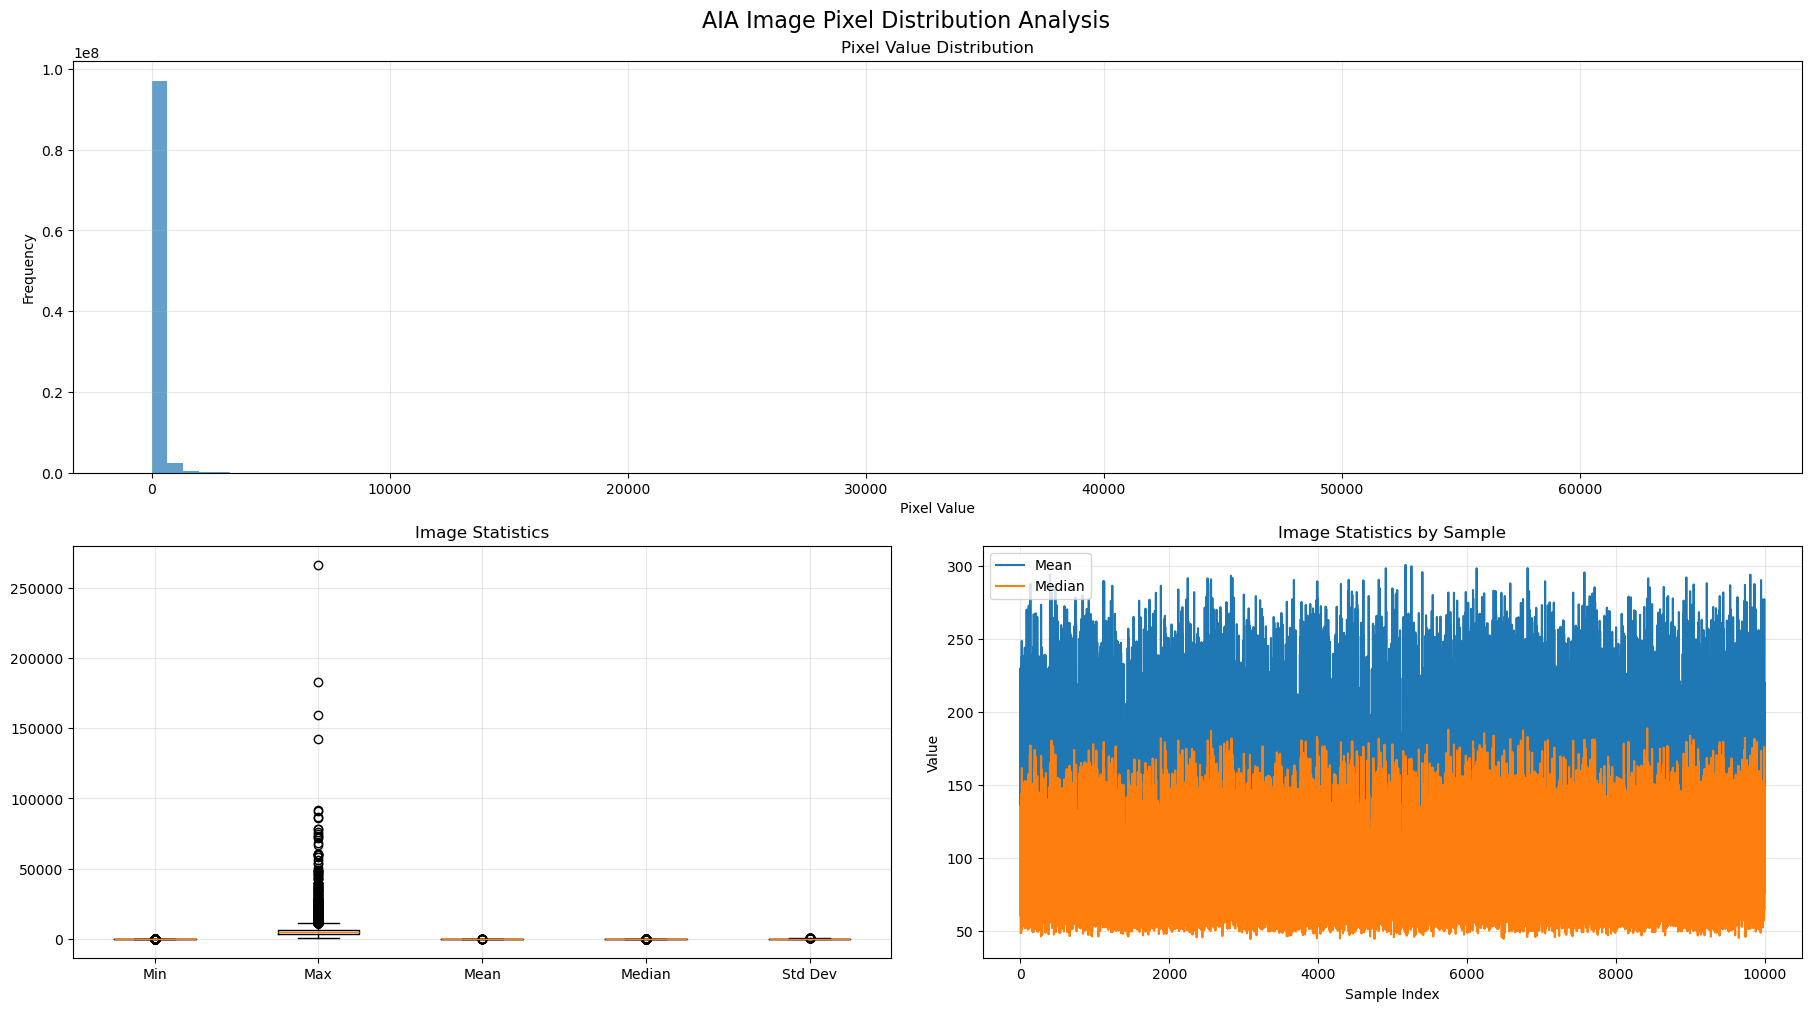

Overall statistics:
Min value: -49.79088898940953
Max value: 266291.993418819
Mean value: 137.9810714233101
Median value: 83.10360445199295
Std Dev: 192.79118089182762
5th percentile: 0.5011073762080943
95th percentile: 484.71966467952416
1 percentile: -0.050471309071916624
99th percentile: 1047.0561621703343


In [23]:
# Calculate pixel value distribution after clipping
pixel_values = []
min_vals = []
max_vals = []
mean_vals = []
median_vals = []
std_vals = []

# Sample a subset of files for faster processing if there are many files
sample_size = min(10000, len(aia_files))
sampled_files = np.random.choice(aia_files, size=sample_size, replace=False)

for aia_file in tqdm(sampled_files, desc="Calculating pixel distribution"):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path) as hdul:
            data = hdul[1].data
            
            # Collect statistics
            min_vals.append(np.min(data))
            max_vals.append(np.max(data))
            mean_vals.append(np.mean(data))
            median_vals.append(np.median(data))
            std_vals.append(np.std(data))
            
            # Sample pixels for histogram (to avoid memory issues)
            flat_data = data.flatten()
            sampled_pixels = flat_data[np.random.randint(0, len(flat_data), size=10000)]
            pixel_values.extend(sampled_pixels)
    except Exception as e:
        print(f"Error processing {aia_file}: {e}")

# Create visualization
fig = plt.figure(figsize=(18, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

# Histogram of all pixel values
ax1 = fig.add_subplot(gs[0, :])
ax1.hist(pixel_values, bins=100, alpha=0.7)
ax1.set_title('Pixel Value Distribution')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Statistics
ax2 = fig.add_subplot(gs[1, 0])
ax2.boxplot([min_vals, max_vals, mean_vals, median_vals, std_vals])
ax2.set_xticklabels(['Min', 'Max', 'Mean', 'Median', 'Std Dev'])
ax2.set_title('Image Statistics')
ax2.grid(True, alpha=0.3)

# Image statistics over time
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(mean_vals, label='Mean')
ax3.plot(median_vals, label='Median')
ax3.set_title('Image Statistics by Sample')
ax3.set_xlabel('Sample Index')
ax3.set_ylabel('Value')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle('AIA Image Pixel Distribution Analysis', fontsize=16)
plt.show()

# Print summary statistics
print(f"Overall statistics:")
print(f"Min value: {np.min(min_vals)}")
print(f"Max value: {np.max(max_vals)}")
print(f"Mean value: {np.mean(mean_vals)}")
print(f"Median value: {np.median(median_vals)}")
print(f"Std Dev: {np.mean(std_vals)}")

# Calculate 5th and 95th percentiles
p5 = np.percentile(pixel_values, 5)
p95 = np.percentile(pixel_values, 95)

# Add to the statistics output
print(f"5th percentile: {p5}")
print(f"95th percentile: {p95}")

# Calculate 5th and 95th percentiles
p1 = np.percentile(pixel_values, 1)
p99 = np.percentile(pixel_values, 99)

# Add to the statistics output
print(f"1 percentile: {p1}")
print(f"99th percentile: {p99}")

In [ ]:
def clip_values(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            # Clip the values between 100 and 5000
            data_clipped = data.clip(100, 5000)
            
            # Save the clipped image
            hdul[1].data = data_clipped
            
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(clip_values, aia_files), total=len(aia_files), desc="Clipping Values"))

In [ ]:
def rescale_to_log10(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            header = hdul[1].header
            data = hdul[1].data
            # Rescale the data to log10 scale
            data_log10 = np.log10(data + 1)  # Adding 1 to avoid log(0)
            
            # Save the rescaled image
            hdul[1].data = data_log10
            
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(rescale_to_log10, aia_files), total=len(aia_files), desc="Rescaling to log10"))


#### Clip and log10

##### clip using 99th and 1 percentile of each image, and then scale with log 10.

In [ ]:
def clip_values(aia_file):
    aia_file_path = os.path.join(download_dir, aia_file)
    try:
        with fits.open(aia_file_path, mode="update", memmap=False) as hdul:
            data = hdul[1].data
            
            p1 = np.max(np.percentile(pixel_values, 1), 1)  # Ensure p1 is at least 0
            p99 = np.percentile(pixel_values, 99)
            # Clip the values between 100 and 5000
            data_clipped = data.clip(p1, p99)
            
            data_log10 = np.log10(data_clipped) 
            
            # Save the clipped image
            hdul[1].data = data_log10
            
    except Exception as e:
        return f"FILE CORRUPTED: {aia_file_path}, Error: {e}"
    
    return None

with ThreadPoolExecutor(max_workers=20) as executor:
    list(tqdm(executor.map(clip_values, aia_files), total=len(aia_files), desc="Clipping Values"))